# Programming Assignment: Бэггинг и случайный лес

Загрузите датасет digits с помощью функции load_digits из sklearn.datasets и подготовьте матрицу признаков X и ответы на обучающей выборке y (вам потребуются поля data и target в объекте, который возвращает load_digits).

Для оценки качества далее нужно будет использовать cross_val_score из sklearn.cross_validation с параметром cv=10. Эта функция реализует k-fold cross validation c k равным значению параметра cv. Мы предлагаем использовать k=10, чтобы полученные оценки качества имели небольшой разброс, и было проще проверить полученные ответы. На практике же часто хватает и k=5. Функция cross_val_score будет возвращать numpy.ndarray, в котором будет k чисел - качество в каждом из k экспериментов k-fold cross validation. Для получения среднего значения (которое и будет оценкой качества работы) вызовите метод .mean() у массива, который возвращает cross_val_score.

С небольшой вероятностью вы можете натолкнуться на случай, когда полученное вами качество в каком-то из пунктов не попадет в диапазон, заданный для правильных ответов - в этом случае попробуйте перезапустить ячейку с cross_val_score несколько раз и выбрать наиболее «типичное» значение. Если это не помогает, то где-то была допущена ошибка.

Если вам захочется ускорить вычисление cross_val_score - можете попробовать использовать параметр n_jobs, но будьте осторожны: в одной из старых версий sklearn была ошибка, которая приводила к неверному результату работы cross_val_score при задании n_jobs отличным от 1. Сейчас такой проблемы возникнуть не должно, но проверить, что все в порядке, не будет лишним.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import cross_validation, datasets, metrics, tree, ensemble, learning_curve, model_selection

import warnings
warnings.filterwarnings('ignore')

C:\Users\ellys\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\ellys\Anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [2]:
X, y = datasets.load_digits(return_X_y = True)

X = pd.DataFrame(X)

In [3]:
cv = 10

**Создайте DecisionTreeClassifier с настройками по умолчанию и измерьте качество его работы с помощью cross_val_score. Эта величина и будет ответом в пункте 1.**

In [31]:
dt_clf = tree.DecisionTreeClassifier(random_state = 1)

dt_clf_cv = model_selection.cross_val_score(dt_clf, X, y, cv = cv)

print(dt_clf_cv)

[ 0.8         0.84153005  0.82320442  0.80555556  0.7877095   0.89944134
  0.90502793  0.82022472  0.83615819  0.78977273]


In [32]:
dt_clf_cv.mean()

0.83086244395038344

**Воспользуйтесь BaggingClassifier из sklearn.ensemble, чтобы обучить бэггинг над DecisionTreeClassifier. Используйте в BaggingClassifier параметры по умолчанию, задав только количество деревьев равным 100.**

**Качество классификации новой модели - ответ в пункте 2. Обратите внимание, как соотносится качество работы композиции решающих деревьев с качеством работы одного решающего дерева.**

In [33]:
bg_clf = ensemble.BaggingClassifier(dt_clf, n_estimators  = 100, random_state = 1)

bg_clf_cv = model_selection.cross_val_score(bg_clf, X, y, cv = cv)

print(bg_clf_cv)

[ 0.88648649  0.95081967  0.91160221  0.94444444  0.9273743   0.98882682
  0.95530726  0.91573034  0.8700565   0.92045455]


In [34]:
bg_clf_cv.mean()

0.92711025726034357

**Теперь изучите параметры BaggingClassifier и выберите их такими, чтобы каждый базовый алгоритм обучался не на всех d признаках, а на √d случайных признаков. Качество работы получившегося классификатора - ответ в пункте 3. Корень из числа признаков - часто используемая эвристика в задачах классификации, в задачах регрессии же часто берут число признаков, деленное на три. Но в общем случае ничто не мешает вам выбирать любое другое число случайных признаков.**

In [54]:
sqrt_d = int(np.sqrt(X.shape[1]))

bg_sq_clf = ensemble.BaggingClassifier(dt_clf, n_estimators  = 100, random_state = 1, max_features = sqrt_d)

bg_sq_clf_cv = model_selection.cross_val_score(bg_sq_clf, X, y, cv = cv)

print(bg_sq_clf_cv)

[ 0.9027027   0.95081967  0.93370166  0.9         0.94413408  0.94413408
  0.97206704  0.98314607  0.89830508  0.90909091]


In [55]:
bg_sq_clf_cv.mean()

0.93381012890755399

**Наконец, давайте попробуем выбирать случайные признаки не один раз на все дерево, а при построении каждой вершины дерева. Сделать это несложно: нужно убрать выбор случайного подмножества признаков в BaggingClassifier и добавить его в DecisionTreeClassifier. Какой параметр за это отвечает, можно понять из документации sklearn, либо просто попробовать угадать (скорее всего, у вас сразу получится). Попробуйте выбирать опять же √d признаков. Качество полученного классификатора на контрольной выборке и будет ответом в пункте 4.**

In [58]:
dt_sq_clf = tree.DecisionTreeClassifier(max_features = 'sqrt')

bg_sqt_clf = ensemble.BaggingClassifier(dt_sq_clf, n_estimators = 100, random_state = 1)

bg_sqt_clf_cv = model_selection.cross_val_score(bg_sqt_clf, X, y, cv = cv)

print(bg_sqt_clf_cv)

[ 0.9027027   0.96174863  0.93370166  0.95        0.96089385  0.98324022
  0.97206704  0.96629213  0.93220339  0.9375    ]


In [59]:
bg_sqt_clf_cv.mean()

0.95003496360214523

## Проверка утверждений

In [13]:
from sklearn.model_selection import GridSearchCV

rf_clf = ensemble.RandomForestClassifier(random_state = 1)
cv = 3

rf_clf.get_params().keys()

dict_keys(['bootstrap', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [28]:
def scores_plot(model, params, title):    
    plt.plot(params, model.cv_results_['mean_train_score'], color = 'blue', label = 'Train')
    plt.plot(params, model.cv_results_['mean_test_score'], color = 'red', label = 'Test')
    plt.xlabel('Параметр')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.title(title)
    plt.show()

### Пункт 1

In [15]:
n_estimators = np.arange(10, 101, 10)

In [22]:
%%time

grid_cv_ntrees = GridSearchCV(rf_clf, {'n_estimators': n_estimators}, cv = cv)

grid_cv_ntrees.fit(X, y)

Wall time: 20.2 s


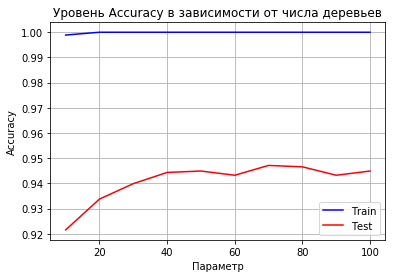

In [29]:
scores_plot(grid_cv_ntrees, n_estimators, 'Уровень Accuracy в зависимости от числа деревьев')

1) Случайный лес сильно переобучается с ростом количества деревьев.

    Ответ: нет. Начиная с определенного числа деревьев уровень Accuracy начинает снижаться (см. График), но не до исходного уровня.

2) При очень маленьком числе деревьев (5, 10, 15), случайный лес работает хуже, чем при большем числе деревьев.

    Ответ: да. Не смотря на то, что при очень большом числе деревьев модель переобучается, она все равно показывает accuracy выше, чем при маленьком их числе (см. График).

3) С ростом количества деревьев в случайном лесе, в какой-то момент деревьев становится достаточно для высокого качества классификации, а затем качество существенно не меняется.
    
    Ответ: нет. После некоторого числа деревьев, качество модели на тестовой выборке начинает постепенно ухудшаться (переобучение).

### Пункт 2

In [24]:
%%time

max_features = np.arange(5, X.shape[1]+1, 5)

grid_cv_features = GridSearchCV(rf_clf, {'max_features': max_features}, cv = cv)

grid_cv_features.fit(X, y)

Wall time: 8.56 s


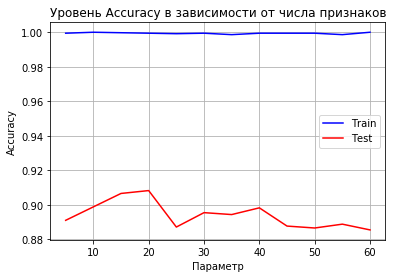

In [30]:
scores_plot(grid_cv_features, max_features, 'Уровень Accuracy в зависимости от числа признаков')

4) При большом количестве признаков (для данного датасета - 40, 50) качество классификации становится хуже, чем при малом количестве признаков (5, 10). Это связано с тем, что чем меньше признаков выбирается в каждом узле, тем более различными получаются деревья (ведь деревья сильно неустойчивы к изменениям в обучающей выборке), и тем лучше работает их композиция.

    Ответ: да.

5) При большом количестве признаков (40, 50, 60) качество классификации лучше, чем при малом количестве признаков (5, 10). Это связано с тем, что чем больше признаков - тем больше информации об объектах, а значит алгоритм может делать прогнозы более точно.

    Ответ: нет.

### Пункт 3

In [26]:
%%time

max_depth = np.arange(5, 300, 5)

grid_cv_depth = GridSearchCV(rf_clf, {'max_depth': max_depth}, cv = cv)

grid_cv_depth.fit(X, y)

Wall time: 24.5 s


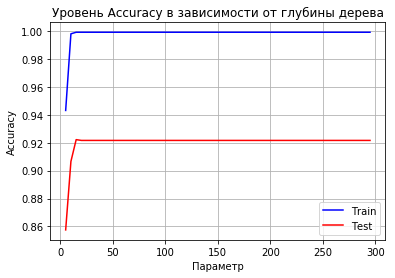

In [31]:
scores_plot(grid_cv_depth, max_depth, 'Уровень Accuracy в зависимости от глубины дерева')

6) При небольшой максимальной глубине деревьев (5-6) качество работы случайного леса намного лучше, чем без ограничения глубины, т.к. деревья получаются не переобученными. С ростом глубины деревьев качество ухудшается.

    Ответ: нет.

7) При небольшой максимальной глубине деревьев (5-6) качество работы случайного леса заметно хуже, чем без ограничений, т.к. деревья получаются недообученными. С ростом глубины качество сначала улучшается, а затем не меняется существенно, т.к. из-за усреднения прогнозов и различий деревьев их переобученность в бэггинге не сказывается на итоговом качестве (все деревья преобучены по-разному, и при усреднении они компенсируют переобученность друг-друга).

    Ответ: да.